# Analysis of Zakka  Canada Customers

In this notebook, I take a look at customer purchase information from a real jewelery display company called Zakka Canada.    I apply the standard BG/NBD model from _lifetimes_ python package to fit and perform inference on the data.  The data details all orders from 2007 to 2015.

In [ ]:
!pip install lifetimes
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from pandas import read_csv
import pandas as pd
from scipy.stats import beta, gamma, invgamma, norm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
from random import uniform 
from statsmodels.api import OLS
import numpy as np
warnings.filterwarnings('ignore')
%cd
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})

     |████████████████████████████████| 583kB 2.8MB/s 
/root


In [ ]:
trans_data = read_csv('data/customer/customer_analytics_orders.csv')
%matplotlib inline

In [ ]:
trans_data['Date'] = pd.to_datetime(trans_data['Date'])
trans_data.head()
print 'Number of Entries: %s' % len(trans_data)

Number of Entries: 22408


The models presented in _lifetimes_ measure customer's __repeat__ purchase behaviors based on his/her recency $x_t$, frequency $x$ and analysis period $T$.  Thus, each customer can be summarized into a vector $(x, t_x, T)$.  We can take our basic customer transaction list and parse it into a usable RF(M) dataframe for the model. We should use the function already made within _lifetimes_ called __summary_data_from_transaction_data()__:
- Recency ($t_x$) is calculated as the most recent transaction within $T$ less time of the first transaction
- Frequency ($x$) is number of repeat transactions the customer has made
- $T$ is equal to the end observation period less first purchase made by the customer (implied age)

The unit of time is in days

In [ ]:
data = summary_data_from_transaction_data(trans_data, 'Customer ID', 'Date', monetary_value_col='Subtotal', observation_period_end='2015-12-31')
data.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
7,2.0,794.0,1117.0,7.57
9,0.0,0.0,3062.0,0.00
30,0.0,0.0,3037.0,0.00
34,0.0,0.0,3115.0,0.00
38,0.0,0.0,3109.0,0.00


count    3498.000000
mean        2.605489
std         2.996117
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        43.000000
Name: frequency, dtype: float64


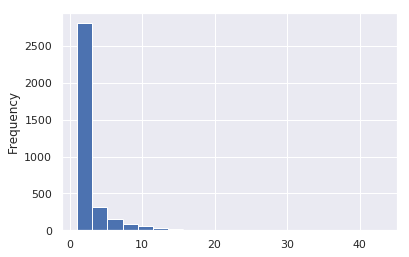

In [ ]:
data[data['frequency'] > 0]['frequency'].plot(kind='hist', bins=20)
print data[data['frequency'] > 0]['frequency'].describe()

Most customers are one time buyers on Zakka Canada with only ~13.6% of customers making two or more repeat purchases while 72.3% of customers only make one purchase.  Below we look at their recency distribution:

0.272663496765
count    3498.000000
mean      441.194969
std       511.513487
min         1.000000
25%        55.000000
50%       245.500000
75%       661.000000
max      2923.000000
Name: recency, dtype: float64


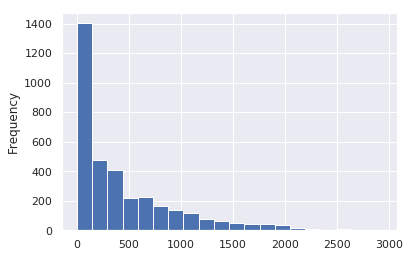

In [ ]:
data[data['recency'] != 0]['recency'].plot(kind='hist', bins=20)
print sum(data['recency'] != 0)/float(len(data))
print data[data['recency'] != 0]['recency'].describe()

Customers that previously have a frequency of zero (customers that have not made repeat purchases) also have a recency of zero so we isolate for repeat customer only.  Considering the analysis ranges within a span of eight years, having 50% of your customer churn before a year (245) is even up and 75% of your customers churn before two years (661) should be a concern

## Fitting the BG/NBD Model

In quick summary, the BG/NBD model assumes that each customer makes repeat purchases at different intervals.  This interval between purchases is modeled by an exponential distribution with a transaction rate $\lambda$.  Furthermore, after each transaction, the customer has a $p%$ chance of going inactive (or dying) which is modelled by a shifted Geometric distribution.  These two major parameters are further refined for heterogenity across customers through a Gamma distribution for $\lambda$ and a Beta distribution for $p$.  Thus we have four total parameters $r$, $\alpha$ (gamma distro) and $a$, $b$ (Beta distro) estimated below:

In [ ]:
# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'], )
print bgf

<lifetimes.BetaGeoFitter: fitted with 12829 subjects, a: 1.31, alpha: 25.33, b: 1.96, r: 0.09>


Since everything goes back to the two major parameters, we can use our heterogenity parameters to model the uncertainty in the two.  As shown below, the probability of a customer dropping out has a large range but mostly centered between 15 to 60% after a certain transaction.  On the other hand, our customer transaction rate falls mostly within 0 and 0.01.

(0.0, 0.02)

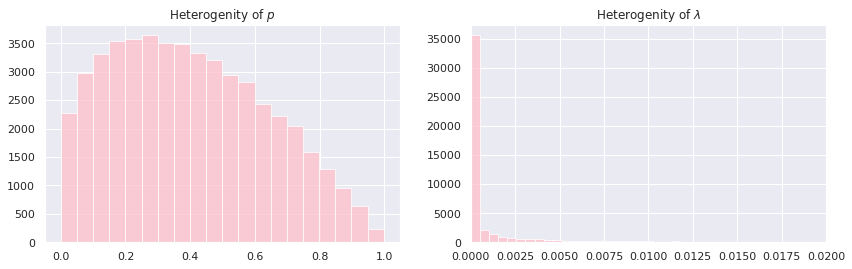

In [ ]:
gbd = beta.rvs(bgf.params_['a'], bgf.params_['b'], size = 50000)
ggd = gamma.rvs(bgf.params_['r'], scale=1./bgf.params_['alpha'], size = 50000)
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.title('Heterogenity of $p$')
temp = plt.hist(gbd, 20, facecolor='pink', alpha=0.75)
plt.subplot(122)
plt.title('Heterogenity of $\lambda$')
temp = plt.hist(ggd, 500, facecolor='pink', alpha=0.75)
plt.xlim(0.0,0.02)

---

## Fact Checking

Peter Fader in his [Youtube talk](https://www.youtube.com/watch?v=guj2gVEEx4s) on CLV provides four simple plots to illustrate the accuracy of the model and its associated behavioral story when applied to real data sets.  I will replicate two of them below on our data to ensure that the model is indeed a good fit for our customers. 

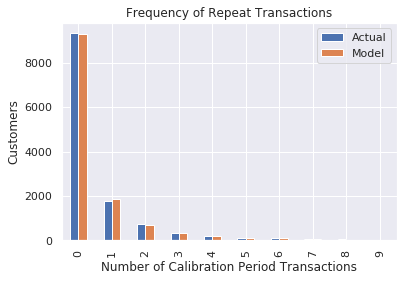

In [ ]:
plot_period_transactions(bgf, max_frequency=10)

After fitting the BG/NBD model, we can fact check through looking at the fitted repeat purchase for the entire customer database.  Above plots the Actual repeat purchase frequency versus the Model repeat purchase frequency.  As shown, the model performs relatively well in fitting the repeat purchase pattern. It overestimates one and six repeat purchases while underestimating three repeat purchases.

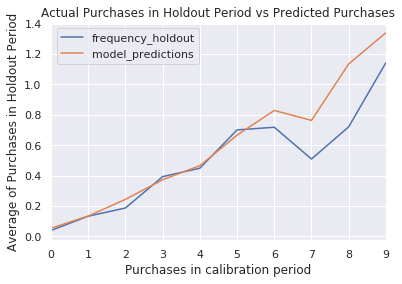

In [ ]:
summary_cal_holdout = calibration_and_holdout_data(trans_data, 'Customer ID', 'Date', 
                                        calibration_period_end='2015-01-01',
                                        observation_period_end='2015-12-19' )   
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, n=10)

We can further validate our model by checking for presence of overfitting.  Separating our dataset into two sets: training (2007- 2014 end) and test (2015), we can fit our model with training and see how well it forecasts our customer's out of sample purchasing habit.  The plot above shows our fitted model prediction (green) versus our out of sample repeat purchase frequency (blue).  Each tick on the x-axis is composed of customers that have been grouped such that they have had $x$ repeat purchases.  the Y axis shows the mean of that group's subsequent repeat purchase.  For example, for all customers within our training period that have had 4 repeat purchases, the same group had on average about 0.42 purchases and the model predicted the same as well.  From this plot, we can see that the model performs relatively well in identifying repeat purchases within the lower ranges (less than 6) but is unable to properly forecast buying behaviors of customers with more frequent purchasing habits. 

------

## R/F Matrix Plots

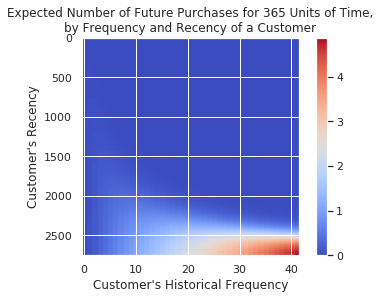

In [ ]:
plot_frequency_recency_matrix(bgf, T=365)

For a given random customer with his/her observed $(x,t_x)$, we can calculate through the model the expected number of purchases within a time period which I have set equivalent to a year.  As shown, customers that purchase frequently and recently have a much higher expected future repeat purchase although this is very slim region on the chart.  For example, unless a customer has purchased recently (say within the past year and a half) and frequently (more than 5 times), don't expect them to show up and place an order within the next year.

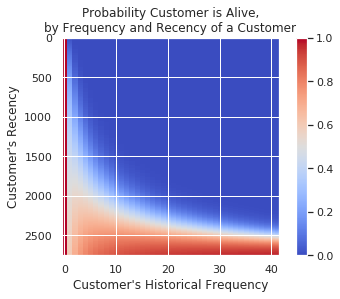

In [ ]:
plot_probability_alive_matrix(bgf)

For a given random customer with his/her observed $(x,t_x)$, we can calculate the probability as of today that they are still alive.  In other words, are they still interested in maintaining a purchasing relationship with our company in the future?  According to the model, it's very likely as long as they bought recently.  Even if they only bought once, they have about a 60-70% chance that they will buy again in the future.  Customers that are considered dead are usually ones that haven't made an order in a while.  

It is interesting to note that for a given recency, customer's with more frequency are more likely to be considered dead.  This is a property of the model that illustrates a clear behavioral story:  If we observe customers making more frequent purchases, then having a prolonged period of inactivity makes it very likely that they've died off.  For example, Two customers $A$ and $B$ that both last purchased 1.5 years ago ($t_x\approx 2700$) but purchased 10 and 30 times respectively.  We believe that it is more likely that customer B has died ($p=0.0$) while customer A still has a fair chance of being alive and making purchases in the future ($p\approx 0.4$).

---

## Analyzing Customer's Historical Path

One last plot that was developed in __lifetimes__ allows us to fully appreciate the model at a granular customer-base level.  Indeed, we can observe each of our customer's historical purchasing path and measure our confidence that they have not dropped out in between purchases.  To get a small and relevant subsample, I will let the _bgf_ model create projections for the next month purchasing pattern of my entire current customer-base and pick out 6 of my best customers.  As shown, our best customers that are projected to make more future repeat purchases are often our newest ones.  This makes sense since the model has revealed to us before that our customer base has a tendency to drop off after a short period of time.

In [ ]:
t = 31
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
best_projected_cust = data.sort_values('predicted_purchases').tail(6)
print data.sort_values('predicted_purchases').tail(6)

             frequency  recency      T  monetary_value  predicted_purchases
Customer ID                                                                
10920             19.0    757.0  801.0       61.354211             0.593733
13527             11.0    318.0  348.0      103.427273             0.693522
14008              9.0    242.0  261.0      124.136667             0.749611
12780             14.0    445.0  461.0      110.073571             0.761943
13577             12.0    247.0  275.0       55.782500             0.893934
14263             17.0    198.0  219.0      323.521176             1.521945


Next, we can plot these six individuals over the course of their lifetime to observe their purchasing behavior.  Among these top 6 customers, they are sorted by expected future purchases ascendingly.  Adding a one month cushion, we can infer the probability that these customers are alive or dead if we have not seen them purchase by the end of the month.  For example, for customer $\tt{14263}$ with a short life-time but very recent purchases, we expect him/her to  return and buy at-leasts once during the month of January.  If however, we don't see this person make an order by the middle of Jan 2016, there is a good chance that they're dead.

Looking at the overall picture, there's not much pattern that can be generalized across all 6 individuals but we can identify certain seasonal behaviors for certain people, for example: 

1. Customer $\tt{13577}$ tends to buy at an equal interval with the exception between September 2015 and Nov 2015.
2. Customers $\tt{12780}$,  $\tt{13527}$ and $\tt{10920}$ tends to buy during the early stage of their life-cycle and then repeat at a much slower interval
3. Customer $\tt{14008}$ first bought at a slower interval but increased his/her frequency over time. We can reasonably assume that they started bying more as their business expanded and became more successful.

TypeError: ignored

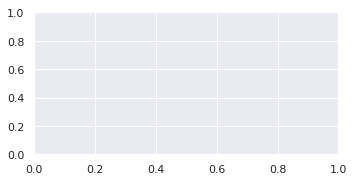

In [ ]:
fig = plt.figure(figsize=(12,12))
for ind,i in enumerate(best_projected_cust.index.tolist()):

  ax = plt.subplot(4,2,ind+1)
  best_T = data.ix[i]['T']+31 #add a month
  best_trans = trans_data[trans_data['Customer ID'] == i].set_index('Customer ID')
  plot_history_alive(bgf, best_T, best_trans, 'Date', freq='D', ax=ax)
  ax.set_title('ID: '+str(i))
  plt.xticks(rotation=25)
  fig.tight_layout()


---

In [ ]:
plot_history_alive(bgf, best_T, best_trans, 'Date', freq='D', ax=ax)

TypeError: ignored

## Customer Value in Dollars: The Gamma-Gamma Model
In a traditional RFM matrix, each customer can be assigned a monetary value with his or her customer profile.  This value is usually calculated as the mean transaction value of his or her purchasing history.  Transaction value is a loosely based word around any metric that the business might be interested in.  Zakka Canada reports an average profit margin of 55%, I will multiply that by the revenue.  Note that we are only interested in customers that have repeat purchases.

In [ ]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ret_cust_data = data[data['frequency'] > 0]
ret_cust_data['monetary_value'] = ret_cust_data['monetary_value']*0.55 # Set Monetary value to gross profit only
ggf.fit(ret_cust_data['frequency'], ret_cust_data['monetary_value'])
p,q,v = ggf._unload_params('p', 'q', 'v')
print ggf 

<lifetimes.GammaGammaFitter: fitted with 3498 subjects, p: 2.66, q: 3.06, v: 39.95>


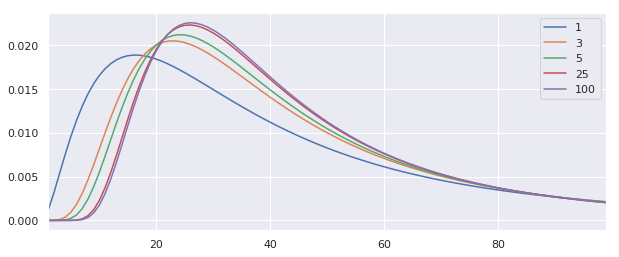

In [ ]:
from scipy.special import beta
def pzbar(zbar,p,q,v,x):
    return (1./(zbar*beta(p*x,q)))*((v/(v+x*zbar))**(q))*(((x*zbar)/(v+x*zbar))**(p*x))

x = range(1,100)
numtrans = [1,3,5,25,100]
dist = pd.DataFrame(0,index=x, columns=numtrans)
for j in range(0,5):
    for i in x:
        dist.loc[i,numtrans[j]] = pzbar(i, p,q,v,numtrans[j])
dist.plot(figsize=(10,4))

The authors now introduce another complicated model to inferring transaction value called the __Gamma-Gamma Model__.  The GG model behaves much like the underlying concepts driving the BGF model: _heterogenity_.  What is the mean transaction value of our customer base? Well we can often estimate that with the sample mean and variance...IF our customer base was symmetrically and normal distributed.  Since this isn't the case (1. non-negative transaction value 2. right skew), we can use the Gamma distribution to approximate the distribution of the mean transaction value ($\bar{z}=\sum_{i} z_i / x$) for EACH customer:
$$\bar{z}\sim Gamma(px,\nu x)$$ Allowing the shape parameter ($\nu$) to be heterogeneous over the entire customer base, here comes the second gamma term:
$$\nu\sim Gamma(q,\gamma)$$

We can calculate the conditional average profit of our customer base versus the observed average profit.  In short, the conditional average profit uses the same concept of unobserved average transaction value in the distribution and provide a shrinkage mean between the unobserved mean and the customer's sample mean.

In [ ]:
avg_cond_profit = ggf.conditional_expected_average_profit(ret_cust_data['frequency'], ret_cust_data['monetary_value'])
print "Expected conditional Average profit: %s, Population Average profit %s, Average profit: %s" % (
    avg_cond_profit, 
    (p*v)/(q-1),
    ret_cust_data['monetary_value'].mean()
)

Expected conditional Average profit: Customer ID
7         17.398160
64        63.168104
101       33.313495
115       76.486057
129       27.009719
136       25.398446
157       40.423064
188       48.952066
216       75.583287
231       59.740608
238       24.876955
246       47.084513
249       91.565335
259       40.946815
269       51.542999
276       31.283518
311       33.666804
325       82.804404
394       37.247535
398       53.036814
404      110.320625
420       48.646417
425       35.107933
435       56.398566
439       33.487124
459       79.981174
461       87.468943
464       23.516919
473       52.416974
493       45.930401
            ...    
15033     40.082152
15035     39.871406
15036     42.150285
15038     29.058292
15039     83.167252
15041     27.710139
15047     43.398297
15056     46.764920
15058    131.880501
15072     44.783640
15089     30.905416
15096    162.265073
15104     30.840333
15106    131.731740
15107     44.538803
15113     38.724701
15132     5

In short, the shrinkage trans. value has the highest average profit followed by what we have observed and lastly the population distribution.  Although these differences are minute, it still implies that the model believes customers are currently slightly under purchasing to their true transaction value.  The shrinkage model also allows us to closely examine the distribution on a customer by customer basis.  Recall that we previously discovered our six best customers for the month of January, let's look at their transaction value we expect from them over the next month.

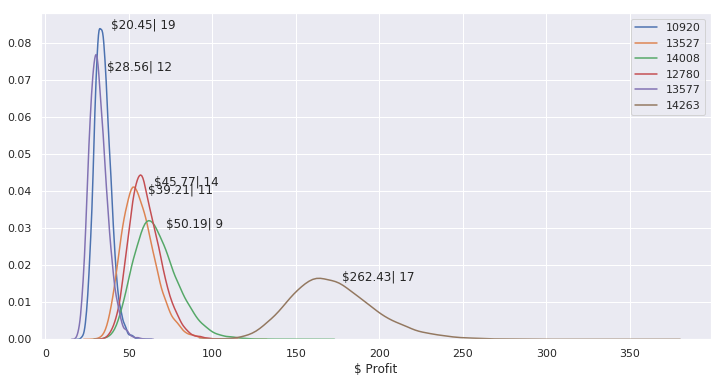

In [ ]:
customer_scale = p*(v+ret_cust_data['frequency']*ret_cust_data['monetary_value'])
customer_shape = p*ret_cust_data['frequency']+q
ez = customer_scale/(customer_shape-1)
best_projected_cust['predicted_purchase_value'] = best_projected_cust['predicted_purchases']*ez
plt.figure(figsize=(12,6))
plt.xlabel('$ Profit')
for ind,i in enumerate(best_projected_cust.index.tolist()):
    ccig = invgamma.rvs(customer_shape[i], scale=customer_scale[i], size = 10000)
    plt.text(ez[i]+5, invgamma.pdf(ez[i], customer_shape[i], scale=customer_scale[i]),
             '$'+str(round(best_projected_cust['predicted_purchase_value'][i],2))
            +'| '+str(int(ret_cust_data.loc[i,'frequency'])))
    sns.distplot(ccig, hist=False, rug=False, label=str(i));

The legends are in the order from least to most expected future purchases (in quantity, not trans. value) for our top 6 customers.  After factoring in their underlying mean purchase distribution, we can gain a lot of insight:
- The order of ranking changes, customer $\texttt{14008}$ is now our second best customer based on his transaction value.
- $\texttt{13577}$ and $\texttt{10920}$ are frequent small buyers, they make frequent purchases worth approximately \$21 to \$28.  Thus, we are more confident about their range of mean transaction prices.
- Conversely, $\texttt{14263}$ being our best customer, purchase infrequently but in large quantities, we are less sure of his mean transaction value but he still stochastically dominates other top customers. 

---

## Valuation: Estimating From the Ground Up

Potential investors interested in a promising company often need to determine how much the company should cost at the present day.  According to traditional financial theory, the cost (also referred to as worth or value) of a company should be equivalent to its discounted future cash flow net of all costs and investments (more on this on the blog).

For Zakka-Canada, it's pretty simple:  The company incurs a profit margin on each order (which I have established as 55% beforehand) and pays a fixed cost each month.  Taking this, we can make a few assumptions on their operations.

#### 1. I took the 2015 annual cost data, divided into equal month payments and used this as the estimate for future fixed cost.

In [ ]:
monthly_fc = 195000/12 # Estimated from 2015 annual data
print 'Estimated Fixed Cost per month: $%s' % monthly_fc

Estimated Fixed Cost per month: $16250


#### 2.  Average annual equity return ranges 6-8%, if Zakka Canada were to sell off their operations today to investors, we can assume a 15% annualized return for the new owners due to its small size.

In [ ]:
dr = 0.15 # An annualized discrete rate
mr = (1+dr)**(1/12.)-1. # Monthly effective rate
print 'Effective Monthly Rate: %s%%' % mr

Effective Monthly Rate: 0.0117149169199%


#### 3. New customer sales have risen historically but stagnated over time with cyclical purchase trends.

Text(0,0.5,'New Customer Cohort Size')

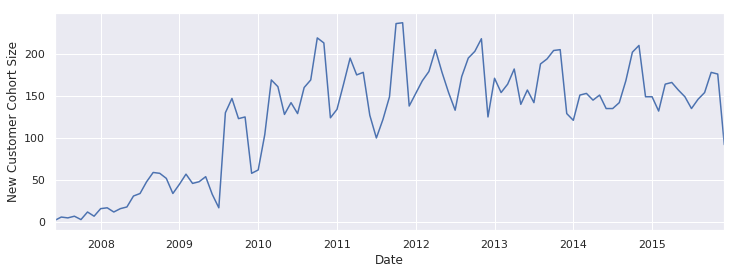

In [ ]:
unique_cohort = trans_data[['Customer ID', 'Date']].sort_values('Date')
unique_cohort = unique_cohort.drop_duplicates('Customer ID')
unique_cohort['Date_M'] = unique_cohort['Date'].apply(lambda x: dt.datetime(day=1,month=x.month,year=x.year))
cohort_over_time = unique_cohort[['Date_M', 'Customer ID']].groupby('Date_M').count()
ax = cohort_over_time.plot(legend=False, figsize=(12,4))
ax.set_xlabel('Date'); ax.set_ylabel('New Customer Cohort Size')

#### 4. Observed customers have their own individual purchasing patterns while the newly arrived customers will assume model population parameters.
---

Given our assumptions, the value of Zakka Canada is simply the summation of:

1. The present value of all new and repeat sales from each month's new cohort of unobserved customers.
2. The present value of all gross profit on repeat sales from our observed customers.
3. Less the present value of fixed cost for each month.

Repeat until infinity.

We first address (1) by forecasting out our seasonal cohort of new customers.  We fit the time-series model to only the stagnation period (2010 and beyond).
$$A_t = C + \sum_{i=1}^{12}{\beta_{i}\delta_{m(t)=i}} $$
Where $\delta_{m(t)}$ is equal to the indicator variable denoting which month $t$ is in.  $C$ is equal to the mean monthly  estimated new arrivals.  Example plot of the arrivals forecast is below but remember that this forecast extends indefinitely as we also believe Zakka Canada can operate to an indefinite horizon.

                            OLS Regression Results                            
Dep. Variable:            Customer ID   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     11.70
Date:                Fri, 26 Jul 2019   Prob (F-statistic):           3.40e-11
Time:                        11:31:38   Log-Likelihood:                -303.76
No. Observations:                  71   AIC:                             631.5
Df Residuals:                      59   BIC:                             658.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
M1            -3.0231      8.150     -0.371      0.7

Text(0,0.5,'New Customer Cohort Size')

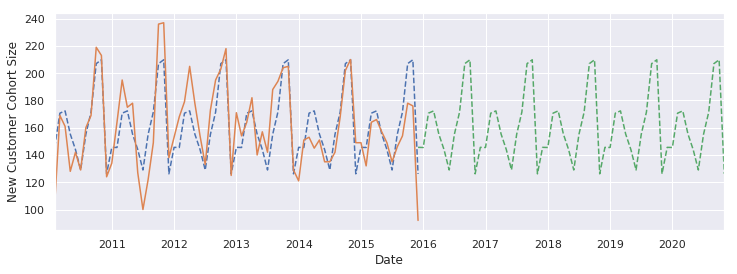

In [ ]:
def prepareDesignMatrix(x):
    x['M'] = x.index.month
    for elem in x['M'].unique():
        x['M'+str(elem)] = (x['M'] == elem).astype(int)
    x['c'] = 1.
    return x.drop('M', axis=1)
cohort_over_time = cohort_over_time[cohort_over_time.index >= dt.datetime(2010,2,1)]
cohort_over_time = prepareDesignMatrix(cohort_over_time)
res = OLS(cohort_over_time['Customer ID'], cohort_over_time[['M1','M2','M3','M4','M5','M6','M7','M8','M9','M10','M11','M12','c']]).fit()
print res.summary()
cohort_over_time['predicted'] = res.predict()
f_cohort = pd.DataFrame(None, index= pd.date_range(cohort_over_time.index.max(), periods=5*12, freq='M'))
f_cohort = prepareDesignMatrix(f_cohort)
f_cohort['forecast'] = res.predict(f_cohort)
cohort_over_time['predicted'].plot(style='--')
cohort_over_time['Customer ID'].plot(legend=None)
ax = f_cohort['forecast'].plot(style='--', figsize=(12,4))
ax.set_xlabel('Date'); ax.set_ylabel('New Customer Cohort Size')

The present value calculation is a bit tricky for both (1) and (2) which we will refer to as Discounted Repeat Value (DRV) and Residual Customer Value (RCV) respectively.  For both these measures, customers will repeatedly buy over multiple periods, these periods are then each discounted back to their present value.  Fader and his colleagues have proposed a closed form calculation for their Pareto/NBD model but not one for BG/NBD.  Through my emails with him and through other authors, they confirm that the actual calculation for BG/NBD model is messy and long so I'm going to approximate it numerically.  We can first start with RCV:

The RCV consists of first predicting the expected purchases of each observed customer given their $(x, t_x, T)$.  We can then infer their expected $Z$ from the GG model as shown before to obtain an expected gross profit from them at each month. Note that our periodicity is monthly while the model calculates in days.  Our __residual value__ formula becomes:
$$RCV = \sum_{t=1}^{\infty}{\frac{\sum_{k=1}^{K}{E(Z\mid p,q,\gamma,\bar{z}_{k},x_{k})(E(Y(30t)\mid x_{k},t_{x,k},T_{k},r,\alpha,a,b)-E(Y(30(t-1))\mid x_{k},t_{x,k},T_{k},r,\alpha,a,b))}}{(1+\delta)^t}}$$
Where $k$ is the k-th customer observed.  See [here](http://www.brucehardie.com/notes/025/gamma_gamma.pdf) and [here](http://mktg.uni-svishtov.bg/ivm/resources/Counting_Your_Customers.pdf) for notation definitions.

In [ ]:
def RCV(t, model_trans, d, rfm, zeta):
    discount_factor = 1./(1+d)**t
    dif = (model_trans.conditional_expected_number_of_purchases_up_to_time(t*30, rfm['frequency'], rfm['recency'], rfm['T'])
        - model_trans.conditional_expected_number_of_purchases_up_to_time((t-1)*30, rfm['frequency'], rfm['recency'], rfm['T']))
    return ((dif*zeta).sum())*discount_factor

The DRV (of only ONE customer) is similar in that we discount the expected gross profit of a generic customer from our two models.
$$DRV = \sum_{t=1}^{\infty}{\frac{E(Z\mid p,q,\gamma)(E(X(30t)\mid r,\alpha,a,b)-E(X(30(t-1))\mid r,\alpha,a,b))}{(1+\delta)^t}}$$
$$ = \sum_{t=1}^{\infty}{\frac{\frac{p\gamma}{q-1}(E(X(30t)\mid r,\alpha,a,b)-E(X(30(t-1))\mid r,\alpha,a,b))}{(1+\delta)^t}}$$
Since the model only measures repeat transactions, we have to consider the fact that when one cohort of customers arrive, they must first make a purchase before beginning they buy until they die.  For example, if one customer enters at $t=0$ we would assume they would have first made a purchase at that time period and then repeat purchases at $t=1,2,3,...,\infty$.
$$ = \sum_{t=1}^{\infty}{\frac{p\gamma}{q-1}(\frac{(E(X(30t)\mid r,\alpha,a,b)-E(X(30(t-1))\mid r,\alpha,a,b))}{(1+\delta)^t}+\delta_{t=1}1)}$$
where $\delta_{t=1}$ is the indicator variable for when if $t=1$.

In [ ]:
def DRV(t, model, d, zeta):
    discount_factor = 1./(1+d)**t
    dif = model.expected_number_of_purchases_up_to_time(t*30) - model.expected_number_of_purchases_up_to_time((t-1)*30)
    return zeta*(dif*discount_factor+(t==1))

Lastly, the DRV is only designed for one customer that arrives at some arbitrary time and buys until infinity.  At each time period $\tau$, a cohort of size $A_t$ arrives and has a present value of $A_t(DRV)$.  If we allow $\tau\rightarrow\infty$ and take the summation of each present value of cohort DRV, we end up with the __terminal value__ of the firm.
$$TV = \frac{A_{1}DRV}{(1+\delta)}+\frac{A_{2}DRV}{(1+\delta)^2}+...+\frac{A_{\infty}DRV}{(1+\delta)^{\infty}}$$
$$ = \sum_{\tau=1}^{\infty}{\frac{A_{\tau}DRV}{(1+\delta)^{\tau}}} $$

In [ ]:
def TermVal(t, model, d, zeta, ts_model, drv):
    q = dt.datetime(2016,1,1)+pd.DateOffset(months=t)
    x = pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0]], index=[q], columns=['M1','M2','M3','M4','M5','M6','M7','M8','M9','M10','M11','M12'])
    cohort_size = ts_model.predict(prepareDesignMatrix(x))[0]
    val = drv * cohort_size/( (1+d)**t )
    #print 'present value of cohort size %s at t = %s : %s' % (cohort_size, t,val)
    return val

def approximate(fn, t=1, eps_tol=1e-6, eps=0, **kwargs):
    eps = 0
    cf = 0
    while True:
        cf += fn(t=t, **kwargs)
        if(cf - eps < eps_tol):
            break
        eps = cf; t+=1
    return cf

In [ ]:
terminal_value = (approximate(TermVal, model=bgf, 
                              d=mr, zeta=(p*v)/(q-1), 
                              ts_model=res, 
                              drv=approximate(DRV, model=bgf, d=mr, zeta=(p*v)/(q-1)),
                              eps_tol=1e-8))
print 'Discount Repeated Value: $%.2f' % terminal_value

Discount Repeated Value: $1355992.08


In [ ]:
residual_value = approximate(RCV, model_trans=bgf, d=mr, rfm=ret_cust_data, zeta=ez)
print 'Residual Customer Value: $%.2f' % residual_value

Residual Customer Value: $198415.97


Let's calculate our firm value

In [ ]:
pv_cost = monthly_fc / mr
print 'Present Value of Fixed Cost: $%.2f' % pv_cost

Present Value of Fixed Cost: $1387120.38


In [ ]:
firm_value = terminal_value + residual_value - pv_cost
print 'Zakka Canada Firm Price: $%.2f' % firm_value

Zakka Canada Firm Price: $167287.67


---

## Miscellaneous

Other stuff that's been tried out before..

                            OLS Regression Results                            
Dep. Variable:            Customer ID   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     3.659
Date:                Fri, 26 Jul 2019   Prob (F-statistic):             0.0166
Time:                        11:33:35   Log-Likelihood:                -339.46
No. Observations:                  71   AIC:                             686.9
Df Residuals:                      67   BIC:                             696.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
isQ1         -26.5882     10.045     -2.647      0.0

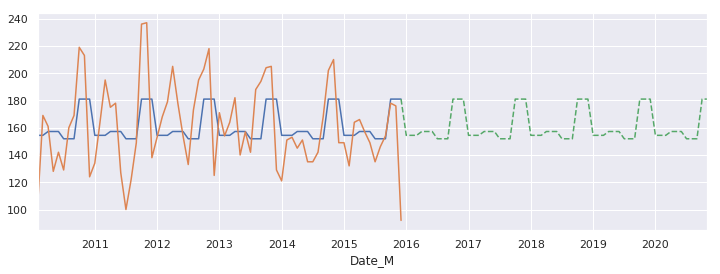

In [ ]:
def prepareDesignMatrix(x):
    x['isQ1'] = [1 if d.quarter == 1 else 0 for d in x.index]; x['isQ2'] = [1 if d.quarter == 2 else 0 for d in x.index]; x['isQ3'] = [1 if d.quarter == 3 else 0 for d in x.index]; x['c'] = 1
    return x
cohort_over_time = cohort_over_time[cohort_over_time.index >= dt.datetime(2010,2,1)]
cohort_over_time = prepareDesignMatrix(cohort_over_time)
res = OLS(cohort_over_time['Customer ID'], cohort_over_time[['isQ1', 'isQ2','isQ3','c']]).fit()
print res.summary()
cohort_over_time['predicted'] = res.predict()
cohort_over_time[['predicted', 'Customer ID']].plot(legend=None)
f_cohort = pd.DataFrame(None, index= pd.date_range(cohort_over_time.index.max(), periods=5*12, freq='M'))
f_cohort = prepareDesignMatrix(f_cohort)
f_cohort['forecast'] = res.predict(f_cohort)
f_cohort['forecast'].plot(style='--', figsize=(12,4))

In [ ]:
growth_value = 0
for t,i in enumerate(f_cohort['forecast']):
    growth_value += (i*approximate(MCV, model=bgf, d=mr, zeta=(p*v)/(q-1)))/ ( (1+mr)**(t+1) )
print growth_value

NameError: ignored